# Week 5 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [1]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/1s/smh2hpds5dx3qkk3b1j6x5dw0000gn/T/pip-req-build-0a9qlyjp


Note: you may need to restart the kernel to use updated packages.


In [17]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud as lucem_illud_2020 #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with, let's create an undirected graph:

In [3]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [4]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [5]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [6]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [7]:
g.nodes[1]

{}

In [8]:
g.nodes[1]['type'] = 'NN'

In [9]:
g.nodes[1]

{'type': 'NN'}

In [10]:
g.nodes[2]['name'] = 'dog'

In [11]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [12]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [13]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

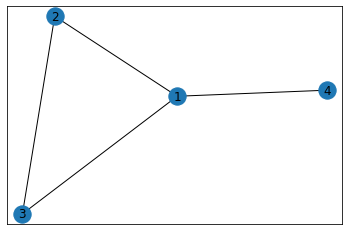

In [14]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: the Grimmer Senate press release corpus:

In [15]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [18]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the sentences:

In [19]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

I'm going to explain the function defined above line by line. But before we look at the function, let's first look at the structure of the data that we use here, senReleasesDF['normalized_sents']. 

In [20]:
senReleasesDF['normalized_sents']

0      [[immediate, release, immediate, release, cont...
1      [[immediate, release, immediate, release, cont...
2      [[immediate, release, immediate, release, wash...
3      [[immediate, release, immediate, release, wash...
4      [[immediate, release, immediate, release, cont...
                             ...                        
995    [[immediate, release, department, house, urban...
996    [[immediate, release], [welcome, today, s, ira...
997    [[immediate, release, immediate, release, wash...
998    [[immediate, release, immediate, release, wash...
999    [[immediate, release, immediate, release], [co...
Name: normalized_sents, Length: 999, dtype: object

As you can see, senReleasesDF['normalized_sents'] is a pandas series, i.e., one-dimensional labeled array that contains any type of data. Each array is comprised of a list of lists. In particular, each array is a list of sentences, each of which is also a list of words. 

In [21]:
senReleasesDF['normalized_sents'][0] #each array is a list of sentences

[['immediate', 'release', 'immediate', 'release', 'contact'],
 ['melissa', 'wagoner'],
 ['brent', 'carney'],
 [],
 [],
 ['boston', 'ma'],
 ['senator',
  'edward',
  'be',
  'kennedy',
  'announce',
  'today',
  'worcester',
  'polytechnic',
  'institute',
  'receive',
  'grant',
  'business',
  'international',
  'education',
  'program',
  'u',
  's',
  'department',
  'education',
  'wpi',
  'use',
  'fund',
  'project',
  'south',
  'africa',
  'improve',
  'understand',
  'south',
  'africa',
  'economy',
  'enable',
  'wpi',
  'student',
  'study',
  'south',
  'africa',
  'strengthen',
  'new',
  'england',
  'company',
  'involvement',
  'south',
  'africa'],
 ['wpi',
  'receive',
  'federal',
  'fund',
  'past',
  'year',
  'business',
  'international',
  'education',
  'program',
  'project',
  'focus',
  'namibia',
  'senator',
  'kennedy',
  'say',
  'principle',
  'challenge',
  'face',
  'country',
  'economy',
  'today',
  'globalization'],
 ['grant',
  'enable',
  'wpi'

In [22]:
senReleasesDF['normalized_sents'][0][4] #each sentence is a list of words

[]

So, what do we want to do with this data? First, we want a list of words that occurred at least once in this corpus. Then, second, we want a word-word co-occurrence matrix. This is a square matrix (i.e. matrix with the name number of rows and columns), the rows and columns of which are words, and the entries of which refer to how many times these two words appeared together in sentences.

Let's start with the first task: getting a complete list of words in the corpus. 

(1) a complete list of unique words that appeared in this corpus

Since the data is a nested list (words are elements of sentences (which are lists) that are elements of lists (documents), we need to get each sentence out of each document and then get each word out of each sentence. So we do "for sent in sentences" to get each sentence out of each document, one by one, to extract word(s) that appeared in each sentence. But, in some sentences, same word appears more than once. So we use set() function, which converts a list (which, here, is each sentence) into a set. What is a set? It's the same old set that we know in mathematics: an unordered collection of items. Each element in a set is unique. Thus, using set(), we can get unique elements (that are, here, words) of each sentence. 

What is the "|=" here? This works as union operation when used with sets (just like +=). Then, we use list() to convert this set of words into a list. 

Then we assign index to each word. You'll see why we do it in the next step--to make the word-word co-occurrence matrix. So we do "wordIndices = {w: i for i, w in enumerate(wordLst)}", which will give us a dictionary whose keys are words and values are indices that we assigned to each word.

(2) word co-occurrence matrix

Now we have the complete list of words that appeared at least once in the corpus (with index assigned to each word). Using this, we want to make word-word co-occurrence matrix.

We first make an empty matrix, the size of which is n x n, where n refers to the number of unique words in the corpus. coOcMat is the empty matrix that we made by "coOcMat = np.zeros((len(wordIndices), len(wordIndices)))"

Then we'll count how many times each pair of words co-occurred in the corpus. So, we do another loop. Each sentence ("sent") has word(s). We want to select each word in a sentence, and find which words co-occurred with this word in each sentence, and then we move on to the next word in a sentence, do the same thing, until we get to the last word in this list (which is, here, a sentence); and, we iterate the whole process for every sentence. 

How did we do it? Let's look at the second loop. By doing "for i, word1 in enumerate(sent):", we select each word in each sentence ("sent"). Then we get the index of this word that we assigned above in the word list (here, be careful, we have two indices here, one refers to the index that we assigned in "wordIndices", and the other to the temporary index in each sentence that we got from "enumerate(sent)"--here, the "index" refers to the former, the one we can find in the wordIndices), by doing: "word1Index = wordIndices[word1]". Then, we count how many times the words next to this word in this list ("sent[i +1:]") co-occurred with this word, and update it to the coOcMat matrix.  

By the way, why do we do "coOcMat = coOcMat.T + coOcMat"?

If you go back and see what the loop does, and think about the characteristics of word-word co-occurrence matrix, it would make sense. Think about the structural characteristics of word-word co-occurrence matrix: it is a square matrix; it's a symmetric matrix (i.e. a square matrix that is equal to its transpose); and, it's main diagonal is zero. That said, in this matrix, let's say A, Aij and Aji are identical. This makes sense since the co-occurrence of i and j and the same as the co-occurrence of j and i. 

Let's go back to the loop we did above, especially how we counted the co-occurrence of each pair of words. We got the index of a word, let's say i, with another words, let's say j, and then we added 1 to Aij, rather than Aji. So, to make this matrix, coOcMat, a word-word co-occurrence matrix, we should add coOcMat and the transpose of this matrix (coOcMat.T).

First, build a graph based on word cooccurences in the first 100 press releases.

In [171]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Why do we do .sum() here? This is because senReleasesDF['normalized_sents'] is, as I mentioned above, a pandas series, and the wordCooccurrence function that we defined above takesa list rather than pandas series. So, by doing senReleasesDF['normalized_sents'].sum(), we combine all the arrays into a list (of course, of lists).

Total number of vertices:

In [172]:
len(g.nodes)

4710

Total number of edges:

In [173]:
len(g.edges)

179321

A part of the adjacency matrix of cleaned word by press releases:

In [174]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [175]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's use the document-word frequency matrix.

In [176]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [29]:
import sklearn.feature_extraction
# in case we get a module not found error

In [30]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [31]:
senVects_incidence.shape

(100, 4710)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [177]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [178]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4810
Number of edges: 21005
Average degree:   8.7339


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

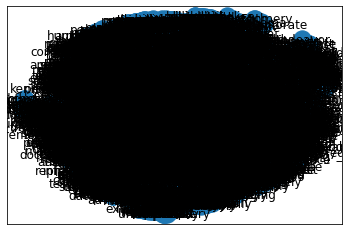

In [34]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [35]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [179]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [37]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

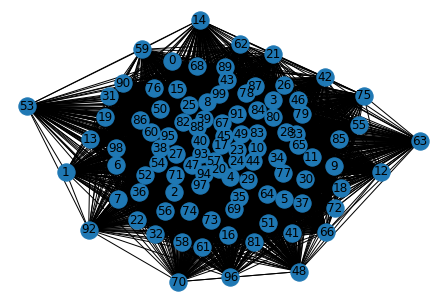

In [180]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

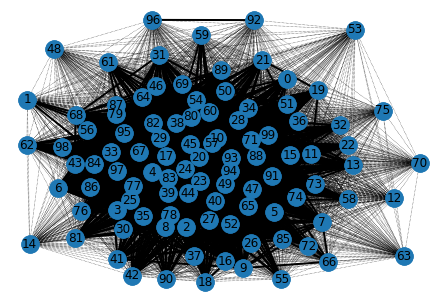

In [39]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [40]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


By the way, what's "iloc" here? iloc is used to select rows and columns in Pandas DataFrame. So,  senReleasesDF.iloc[63] gives the 63th row of senReleasesDF; and since we also specified the column (['text']), it gives us the text of the 63th row.

In [41]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [42]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4710
Number of edges: 2063890
Average degree: 876.3864


First, let's reduce the number of words to a manageable size.

In [43]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.7778965933261948

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [181]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [182]:
len(g)

4710

In [183]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [184]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [185]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [186]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 175
Number of edges: 513
Average degree:   5.8629


A bit smaller now, Now, let's visualize it: 

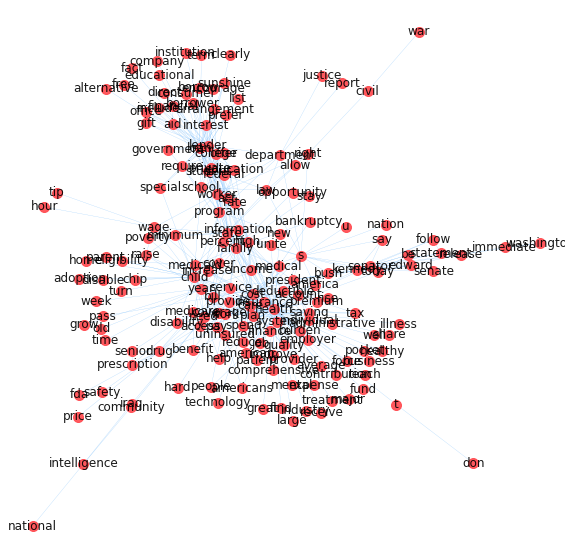

In [187]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [188]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [189]:
c

[frozenset({'access',
            'account',
            'act',
            'administrative',
            'adoption',
            'aid',
            'allow',
            'alternative',
            'america',
            'american',
            'americans',
            'arrangement',
            'average',
            'bankruptcy',
            'be',
            'benefit',
            'bill',
            'borrow',
            'borrower',
            'burden',
            'bush',
            'business',
            'care',
            'child',
            'chip',
            'civil',
            'clearly',
            'college',
            'community',
            'company',
            'comprehensive',
            'consumer',
            'contribution',
            'cost',
            'cover',
            'coverage',
            'deductible',
            'department',
            'direct',
            'disability',
            'disable',
            'don',
            'drug',
          

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [190]:
giant = nx.Graph(giant)

In [191]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 175
Number of edges: 513
Average degree:   5.8629


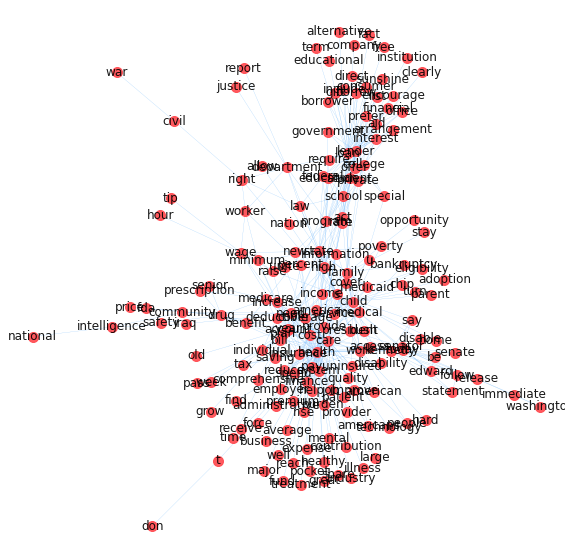

In [55]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [56]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

interest, offer, lender, college, private, loan


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [57]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 11
Average degree:   4.4000


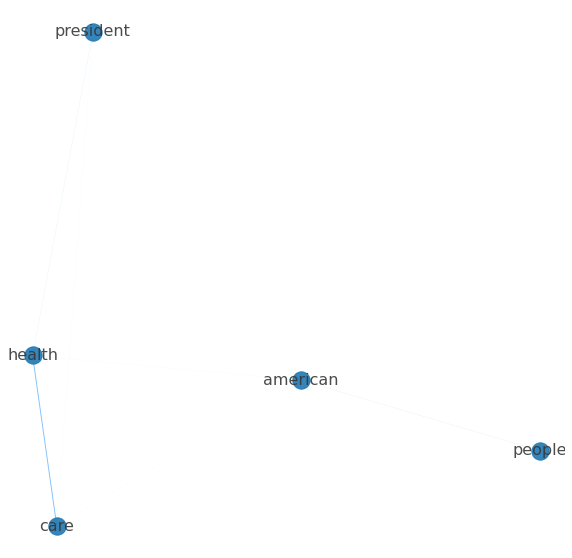

In [58]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [59]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [60]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 171
Number of edges: 502
Average degree:   5.8713


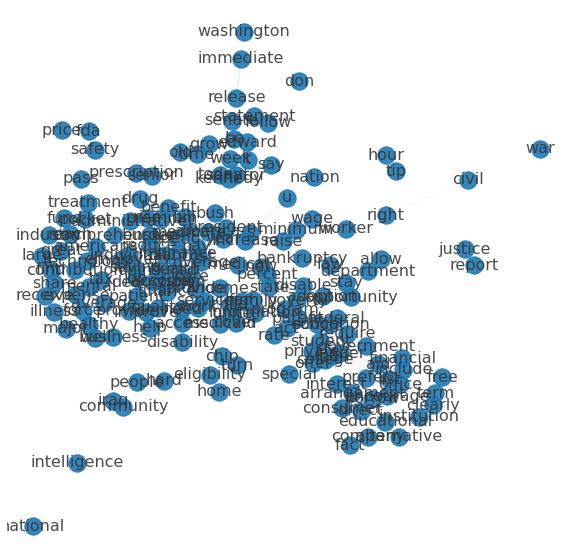

In [61]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [883]:
#pip install pygraphviz

In [63]:
import pandas as pd

In [64]:
exec_orders = pd.read_csv('/Users/lilygrier/Documents/Grad_School/Computational Content Analysis/exec_orders_w_text')

In [68]:
exec_orders[:3]

Unnamed: 0    citation document_number  end_page  \
0           0  82 FR 8115      2017-01623      8129   
1           1  82 FR 7619      2017-01487      7620   
2           2  82 FR 7621      2017-01489      7622   

                                            html_url  \
0  https://www.federalregister.gov/documents/2017...   
1  https://www.federalregister.gov/documents/2017...   
2  https://www.federalregister.gov/documents/2017...   

                                             pdf_url                   type  \
0  https://www.govinfo.gov/content/pkg/FR-2017-01...  Presidential Document   
1  https://www.govinfo.gov/content/pkg/FR-2017-01...  Presidential Document   
2  https://www.govinfo.gov/content/pkg/FR-2017-01...  Presidential Document   

           subtype publication_date signing_date  start_page  \
0  Executive Order       01/23/2017   01/17/2017        8115   
1  Executive Order       01/19/2017   01/13/2017        7619   
2  Executive Order       01/19/2017   01/13/2017        7621   

                                               title  \
0  Amending the Civil Service Rules, Executive Or...   
1  Providing an Order of Succession Within the De...   
2  Providing an Order of Succession Within the En...   

                                   disposition_notes  executive_order_number  \
0  Amends: EO 13467, June 30, 2008; EO 13488, Jan...                 13764.0   
1  Revokes: EO 13557, November 4, 2010\nRevoked b...                 13762.0   
2                 Revokes: EO 13737, August 12, 2016                 13763.0   

      president                                         order_text  
0  barack_obama  \n\nTitle 3—\nThe President\n\nExecutive Order...  
1  barack_obama  \n\n\nExecutive Order 13762 of January 13, 201...  
2  barack_obama  \n\n\nExecutive Order 13763 of January 13, 201...

In [74]:
# filter for orders that have text
exec_orders = exec_orders[exec_orders['order_text'].notnull()]
exec_orders.shape

(839, 16)

In [75]:
# start by tokenizing the sentences
exec_orders['tokenized_sents'] = exec_orders['order_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
exec_orders['normalized_sents'] = exec_orders['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [85]:
exec_orders['tokenized_sents'][0][12]

['2.1',
 'Competitive',
 'examinations',
 'and',
 'eligible',
 'registers',
 'suitability',
 'and',
 'fitness',
 'for',
 'civil',
 'service',
 'employment']

In [89]:
# make smaller dataframe with 25 orders from each of the 4 presidents in the dataset
small_exec = exec_orders.groupby('president').sample(n=25, random_state=1)

In [275]:
g = wordCooccurrence(small_exec['normalized_sents'].sum())

In [276]:
# total number of vertices
len(g.nodes)

3996

In [277]:
# total number of edges
len(g.edges)

262361

In [278]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]])

Now let's look at a two-mode network for this corpus.

In [287]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(small_exec['order_text'])


In [288]:
senVects_incidence.shape

(100, 3995)

In [289]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [290]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4095
Number of edges: 24769
Average degree:  12.0972


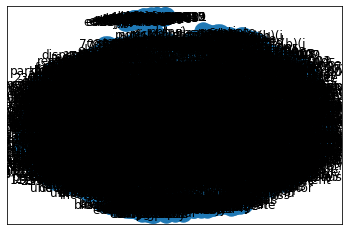

In [291]:
nx.draw_networkx(g_2mode)

In [292]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


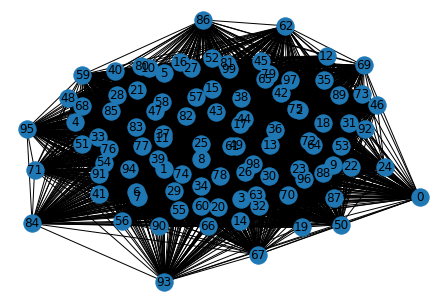

In [293]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()})

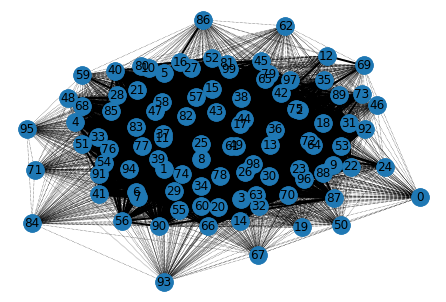

In [294]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Let's look at 93, which appears to be on the outside of the graph.

In [298]:
print(len(small_exec.iloc[93]['order_text']),"words:","\n",small_exec.iloc[93]['order_text'].strip().replace('  ', '\n'))

724 words: 
 Executive Order 13188 of January 12, 2001
Amendment to Executive Order 13111, Extension of the 
Advisory Committee on Expanding Training Opportunities
By the authority vested in me as President by the Constitution and the laws of the United States, including the Federal Advisory Committee Act, as amended (5 U.S.C. App.), and in order to extend the Advisory Committee on Expanding Training Opportunities for 2 years, it is hereby ordered that section 7(f) of Executive Order 13111 of January 12, 1999, is amended by deleting “2 years from the date of this order” and inserting “on January 11, 2003” in lieu thereof.
wj
THE WHITE HOUSE,
January 12, 2001. 
[FR Doc. 01-1736
Filed 1-17-01; 8:45 am]
Billing code 3195-01-P


Now let's look at 25, which is on the inside of the network.

In [299]:
print(len(small_exec.iloc[25]['order_text']),"words:","\n",small_exec.iloc[25]['order_text'].strip().replace('  ', '\n'))

10389 words: 
 Title 3—
The President

Executive Order 13874 of June 11, 2019
Modernizing the Regulatory Framework for Agricultural Biotechnology Products
By the authority vested in me as President by the Constitution and the laws of the United States of America, and in order to conduct Federal oversight of agricultural biotechnology products that is science-based, timely, efficient, and transparent, it is hereby ordered as follows:

Section 1. Purpose. Recent advances in biotechnology have the potential to revolutionize agriculture and thereby enhance rural prosperity and improve the quality of American lives. Biotechnology can help the Nation meet its food production needs, raise the productivity of the American farmer, improve crop and animal characteristics, increase the nutritional value of crop and animal products, and enhance food safety. In order to realize these potential benefits, however, the United States must employ a science-based regulatory system that evaluates products

25 is a lot longer than 93, so it is more likely to have relationships with other texts in the corpus and therefore be more central.

Now let's look at the word-to-word network.

In [301]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3995
Number of edges: 1687934
Average degree: 845.0233


In [302]:
# reduce number of words to manageable size

wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.310292937994021

The word cooccurrence graph seems to reveal more relationships, so I will continue with that one. This dataset is too large as it is. We will filter it by dropping all edges with weight under 25 and dropping all the isolates.

In [849]:
g = wordCooccurrence(small_exec['normalized_sents'].sum())

In [850]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 30])

In [851]:
g.remove_nodes_from(list(nx.isolates(g)))

In [852]:
len(g.nodes)

442

In [853]:
len(g.edges)

2684

In [854]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [855]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 418
Number of edges: 2658
Average degree:  12.7177


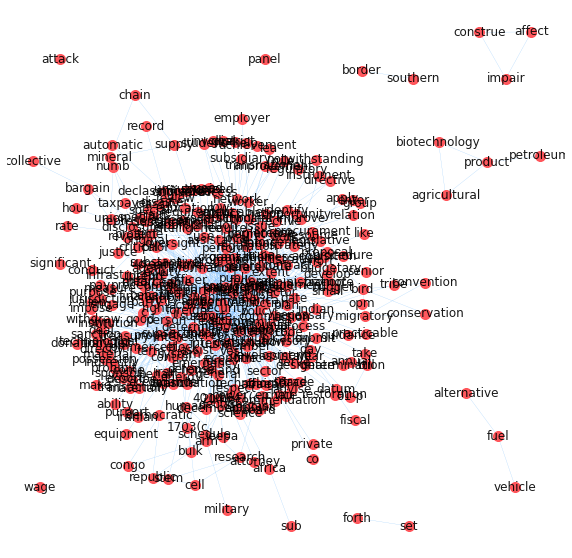

In [884]:
layout = nx.nx_agraph.graphviz_layout(giant)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We see words such as disability and employment occurring together, which makes sense in the context of executive orders. We also see species and habitat near each other, which are probably our environmental conservation acts.

In [857]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [859]:
#c

Let's see what happens when we set get rid of words that occur in many documents. Because there is so much similarity between executive orders, I'm going to set this threshold at 100.


In [860]:
giant = nx.Graph(giant)

In [861]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 100]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 332
Number of edges: 1401
Average degree:   8.4398


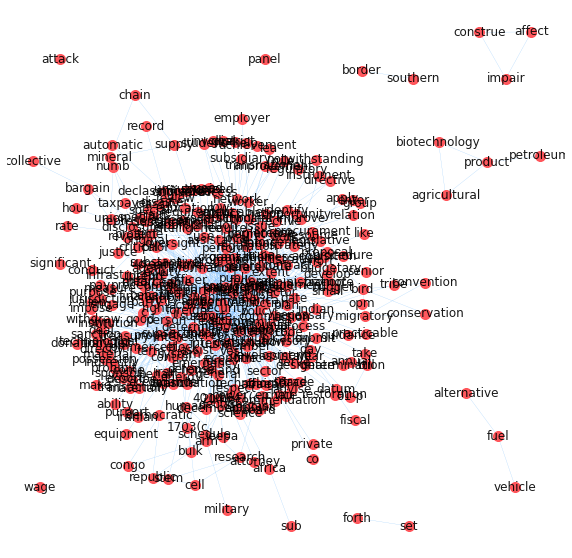

In [886]:
layout = nx.nx_agraph.graphviz_layout(giant)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [867]:
# let's look for cliques now
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

law, benefit, agent, party, employee, create, intend, person, department, procedural, substantive, entity, equity, officer, enforceable, right


In [868]:
energyNeighbors = giant.neighbors('energy')
g_energy = giant.subgraph(energyNeighbors)
print(nx.info(g_energy))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 6
Average degree:   4.0000


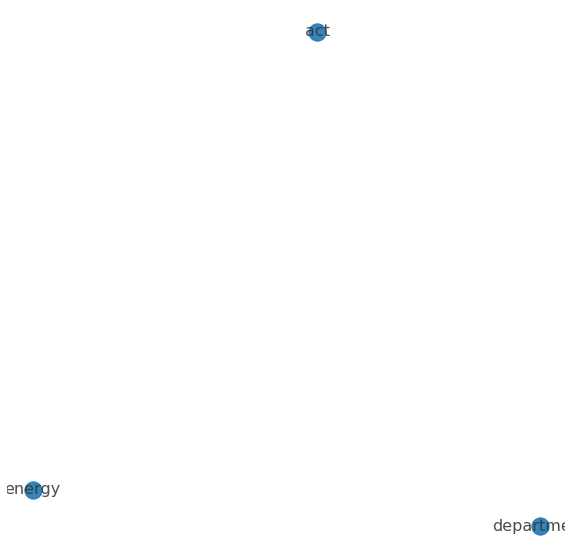

In [869]:
layout_energy = nx.spring_layout(g_energy, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_energy.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_energy.edges(data = True)))
nx.draw(g_energy, ax = ax, pos = layout_energy, labels = {n:n for n in g_energy.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_energy.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [870]:
energyNeighbors = gWord.neighbors('energy')
energyNeighborsPlus1 = set(energyNeighbors)
for n in energyNeighbors:
    energyNeighborsPlus1 |= set(giant.neighbors(n))

In [871]:
g_energy2 = giant.subgraph(energyNeighborsPlus1)
print(nx.info(g_energy2))

Name: 
Type: Graph
Number of nodes: 313
Number of edges: 1340
Average degree:   8.5623


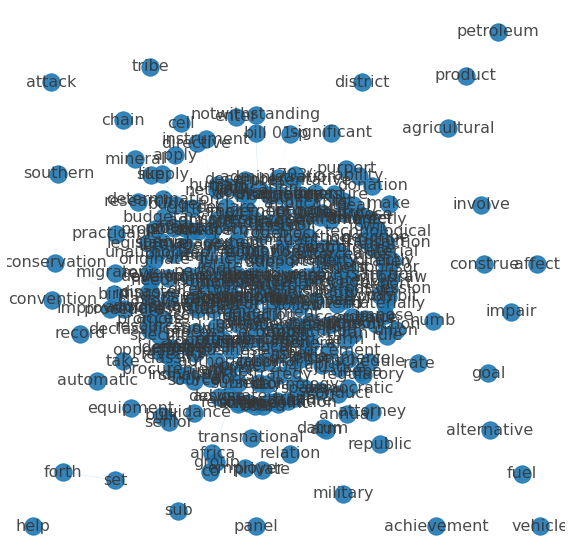

In [888]:
layout_energy = nx.nx_agraph.graphviz_layout(g_energy2)
fig, ax = plt.subplots(figsize = (10,10))
centralities_energy = nx.eigenvector_centrality(g_energy2)
maxC = max(centralities_energy.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_energy2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_energy2.edges(data = True)))
nx.draw(g_energy2, ax = ax, pos = layout_energy, labels = {n:n for n in g_energy2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_energy2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [192]:
dcentralities = nx.degree_centrality(giant)

In [193]:
dcentralities['american']

0.034482758620689655

In [194]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

[('health', 0.4942528735632184),
 ('loan', 0.23563218390804597),
 ('care', 0.21264367816091953),
 ('lender', 0.21264367816091953),
 ('cost', 0.1896551724137931),
 ('child', 0.1781609195402299),
 ('state', 0.14942528735632182),
 ('year', 0.13793103448275862),
 ('family', 0.13218390804597702),
 ('s', 0.12068965517241378),
 ('high', 0.09770114942528735),
 ('kennedy', 0.09195402298850575),
 ('program', 0.09195402298850575),
 ('plan', 0.08620689655172414),
 ('student', 0.08045977011494253),
 ('need', 0.08045977011494253),
 ('senator', 0.08045977011494253),
 ('drug', 0.07471264367816091),
 ('college', 0.07471264367816091),
 ('medicare', 0.06896551724137931),
 ('department', 0.06321839080459771),
 ('president', 0.06321839080459771),
 ('work', 0.06321839080459771),
 ('private', 0.06321839080459771),
 ('wage', 0.05747126436781609),
 ('account', 0.05747126436781609),
 ('education', 0.05747126436781609),
 ('bill', 0.05172413793103448),
 ('school', 0.05172413793103448),
 ('offer', 0.05172413793103

In [195]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.4942528735632184)

By the way, why do we have .items() here? This is because decentralities is a dictionary.

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

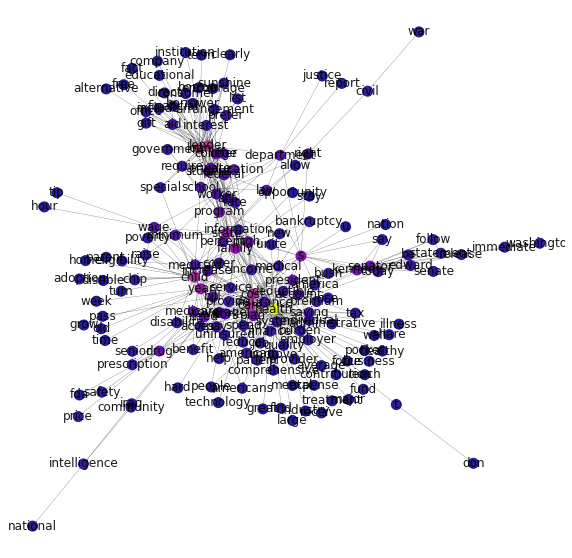

In [196]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

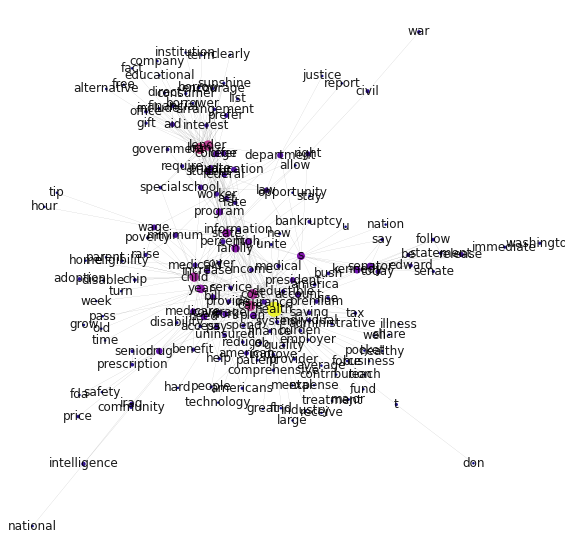

In [197]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

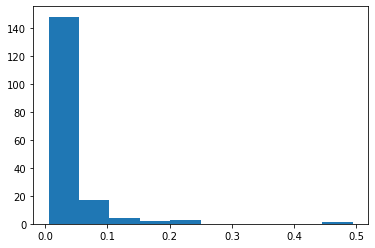

In [198]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [199]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.4942528735632184),
 ('loan', 0.23563218390804597),
 ('care', 0.21264367816091953),
 ('lender', 0.21264367816091953),
 ('cost', 0.1896551724137931),
 ('child', 0.1781609195402299),
 ('state', 0.14942528735632182),
 ('year', 0.13793103448275862),
 ('family', 0.13218390804597702),
 ('s', 0.12068965517241378)]

In [200]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('illness', 0.005747126436781609),
 ('large', 0.005747126436781609),
 ('find', 0.005747126436781609),
 ('opportunity', 0.005747126436781609),
 ('reach', 0.005747126436781609),
 ('week', 0.005747126436781609),
 ('contribution', 0.005747126436781609),
 ('healthy', 0.005747126436781609),
 ('business', 0.005747126436781609),
 ('turn', 0.005747126436781609)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [201]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [202]:
centralities['american']

0.0031344588231816796

In [203]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.49608076383939514)

We can color and size the nodes by betweenness centrality:

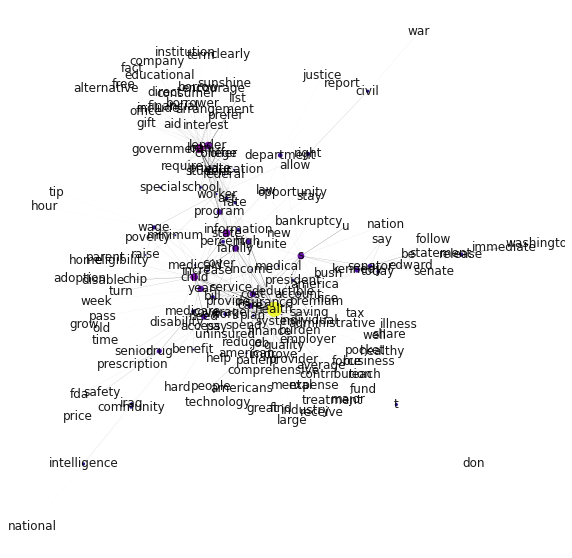

In [204]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

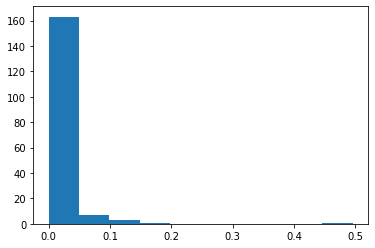

In [205]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [206]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.4942528735632184),
 ('loan', 0.23563218390804597),
 ('care', 0.21264367816091953),
 ('lender', 0.21264367816091953),
 ('cost', 0.1896551724137931),
 ('child', 0.1781609195402299),
 ('state', 0.14942528735632182),
 ('year', 0.13793103448275862),
 ('family', 0.13218390804597702),
 ('s', 0.12068965517241378)]

What are words lower down?

In [207]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('medical', 0.028735632183908046),
 ('iraq', 0.028735632183908046),
 ('interest', 0.028735632183908046),
 ('premium', 0.028735632183908046),
 ('rate', 0.028735632183908046),
 ('uninsured', 0.028735632183908046),
 ('individual', 0.028735632183908046),
 ('intelligence', 0.028735632183908046),
 ('information', 0.028735632183908046),
 ('deductible', 0.028735632183908046)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [208]:
centralities = nx.closeness_centrality(giant)

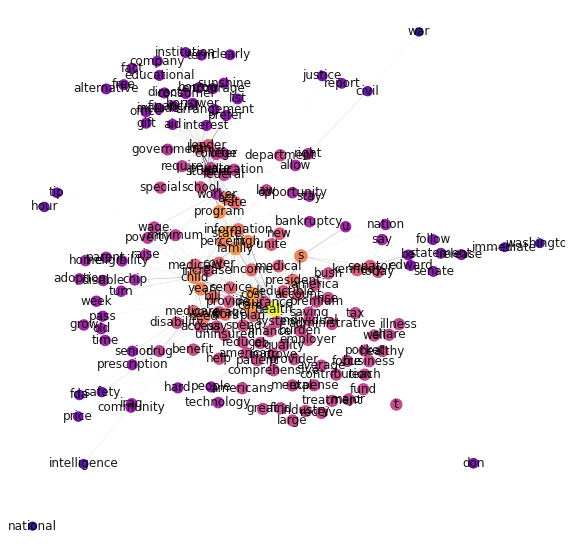

In [209]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [210]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.5761589403973509),
 ('state', 0.49014084507042255),
 ('cost', 0.481994459833795),
 ('care', 0.47540983606557374),
 ('family', 0.47411444141689374),
 ('program', 0.46524064171123),
 ('child', 0.46153846153846156),
 ('high', 0.45910290237467016),
 ('year', 0.45430809399477806),
 ('s', 0.45077720207253885)]

In [211]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('hour', 0.26165413533834586),
 ('fda', 0.25970149253731345),
 ('safety', 0.25970149253731345),
 ('price', 0.25970149253731345),
 ('civil', 0.25290697674418605),
 ('intelligence', 0.23770491803278687),
 ('washington', 0.22422680412371135),
 ('immediate', 0.22422680412371135),
 ('war', 0.20209059233449478),
 ('national', 0.19226519337016573)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [212]:
centralities = nx.eigenvector_centrality(giant)

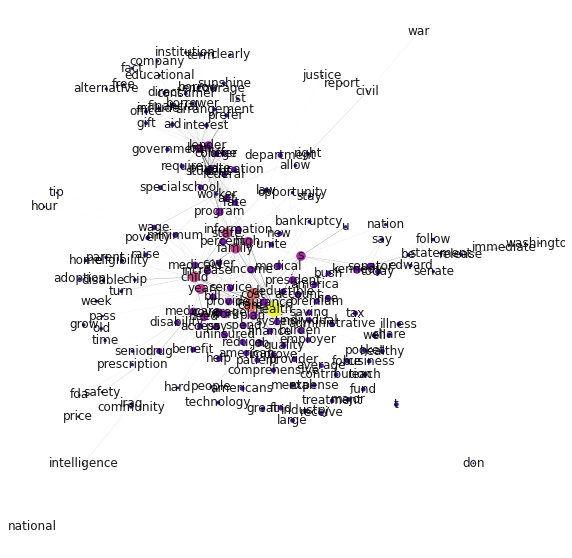

In [213]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

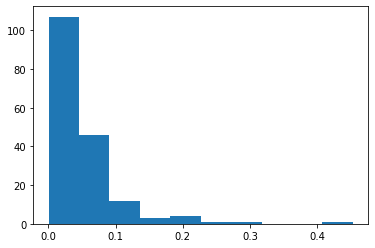

In [214]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [215]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.4532867710882125),
 ('care', 0.2803934410854335),
 ('cost', 0.2668470828468541),
 ('child', 0.21149934262445438),
 ('family', 0.20483711235302174),
 ('state', 0.20154297058889087),
 ('year', 0.18846639486336125),
 ('high', 0.17065479018275384),
 ('s', 0.16292975411409372),
 ('loan', 0.14376206666080554)]

In [216]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('hour', 0.0027972606795261747),
 ('justice', 0.0026389497588123357),
 ('report', 0.0026389497588123357),
 ('don', 0.0020600827285974428),
 ('intelligence', 0.0014726167994067473),
 ('civil', 0.0013452008084728954),
 ('washington', 0.0011604701181495709),
 ('immediate', 0.0011604701181495709),
 ('national', 9.905116502230508e-05),
 ('war', 9.700820627635992e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [163]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [164]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 113
Average degree:   9.0400


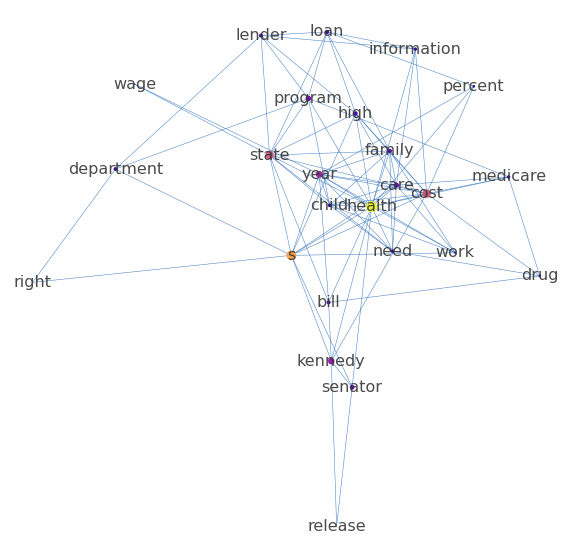

In [165]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [166]:
nx.density(giant)

0.03369458128078818

We can also calculate the average degree per node:

In [167]:
np.mean([v for w,v in nx.degree(giant)])

5.862857142857143

The diameter calculates the average distance between any two nodes in the network:

In [168]:
nx.diameter(giant)

8

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [891]:
dcentralities = nx.degree_centrality(giant)

In [892]:
dcentralities['energy']

0.012084592145015106

In [893]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

[('law', 0.2537764350453172),
 ('person', 0.25075528700906347),
 ('president', 0.22054380664652568),
 ('federal', 0.2054380664652568),
 ('information', 0.18731117824773413),
 ('executive', 0.18126888217522658),
 ('property', 0.1661631419939577),
 ('provide', 0.16314199395770393),
 ('act', 0.16314199395770393),
 ('national', 0.15709969788519637),
 ('department', 0.15709969788519637),
 ('government', 0.13897280966767372),
 ('security', 0.13897280966767372),
 ('service', 0.11178247734138973),
 ('u.s.c', 0.10876132930513595),
 ('pursuant', 0.09063444108761329),
 ('appropriate', 0.08459214501510574),
 ('school', 0.08459214501510574),
 ('authority', 0.0755287009063444),
 ('policy', 0.07250755287009064),
 ('office', 0.06948640483383686),
 ('employee', 0.06948640483383686),
 ('director', 0.06646525679758308),
 ('emergency', 0.06646525679758308),
 ('program', 0.06646525679758308),
 ('committee', 0.06646525679758308),
 ('activity', 0.06646525679758308),
 ('foreign', 0.0634441087613293),
 ('inter

In [894]:
max(dcentralities.items(), key = lambda x : x[1])

('law', 0.2537764350453172)

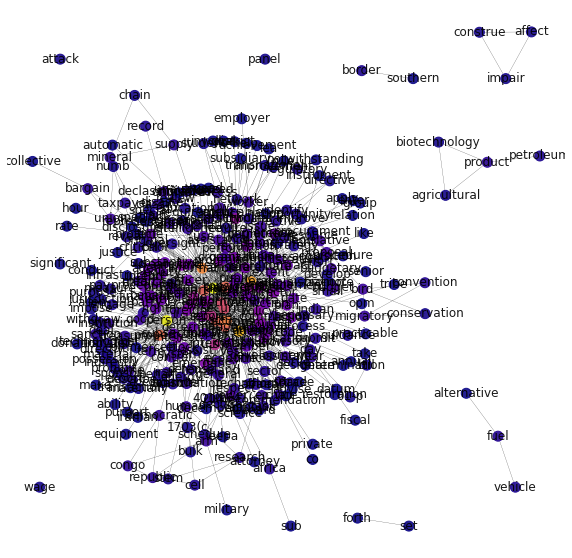

In [895]:
layout = nx.nx_agraph.graphviz_layout(giant)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

In [896]:
layout = nx.nx_agraph.graphviz_layout(giant)
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

Let's look at the distribution of degree centrality.

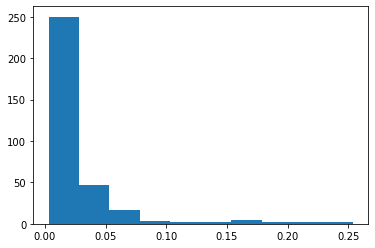

In [897]:
plt.hist(list(dcentralities.values()))
plt.show()

In [898]:
# top 10 words in terms of degree centrality
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('law', 0.2537764350453172),
 ('person', 0.25075528700906347),
 ('president', 0.22054380664652568),
 ('federal', 0.2054380664652568),
 ('information', 0.18731117824773413),
 ('executive', 0.18126888217522658),
 ('property', 0.1661631419939577),
 ('provide', 0.16314199395770393),
 ('act', 0.16314199395770393),
 ('national', 0.15709969788519637)]

In [899]:
# bottom 10 words in terms of degree centrality
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('co', 0.0030211480362537764),
 ('goal', 0.0030211480362537764),
 ('datum', 0.0030211480362537764),
 ('take', 0.0030211480362537764),
 ('employer', 0.0030211480362537764),
 ('specific', 0.0030211480362537764),
 ('significant', 0.0030211480362537764),
 ('southern', 0.0030211480362537764),
 ('unauthorized', 0.0030211480362537764),
 ('lea', 0.0030211480362537764)]

The top 10 words are not surprising, as they seem characteristic of executive orders. The bottom 10 words include roman numerals or incomplete words ('vi', 'lea') that got flagged as words.

Now let's look at betweenness!

In [900]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [901]:
centralities['labor']

0.006562478833399489

In [902]:
max(centralities.items(), key = lambda x : x[1])

('person', 0.14409269559309731)

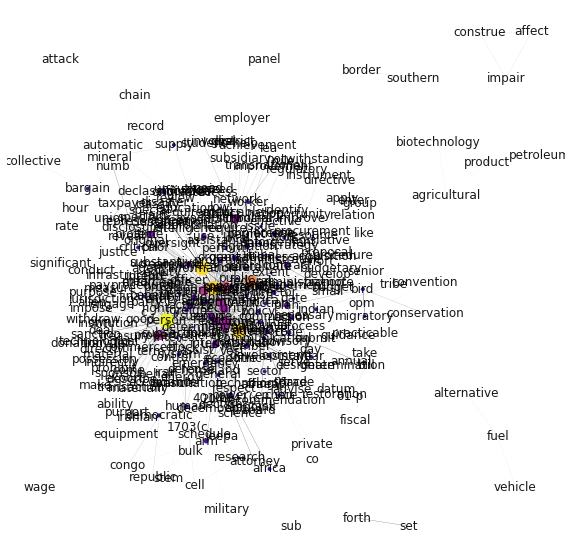

In [903]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

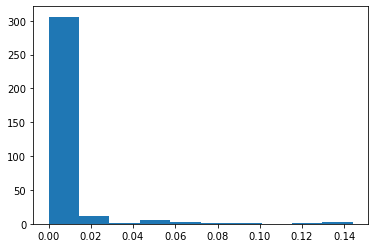

In [904]:
# distribution of betweenness centrality
plt.hist(list(centralities.values()))
plt.show()

In [905]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('person', 0.14409269559309731),
 ('information', 0.13377792289093948),
 ('president', 0.13135174020079848),
 ('law', 0.12896347608397254),
 ('federal', 0.10031376636941845),
 ('provide', 0.07401701259354118),
 ('department', 0.06140139415032637),
 ('property', 0.05988105415740838),
 ('government', 0.05337739762809252),
 ('executive', 0.05138564083142031)]

In [906]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('force', 0.006184937621459395),
 ('appropriate', 0.006091041040038579),
 ('financial', 0.005970714055696503),
 ('emergency', 0.005948806734755314),
 ('general', 0.0058413671817546635),
 ('worker', 0.005810661585917253),
 ('supply', 0.005788548576682452),
 ('chair', 0.00574703364321601),
 ('africa', 0.005731026274832921),
 ('year', 0.005731026274832921)]

Betweenness seems to pick up on similar words to degree centrality, but includes "school," a salient word in executive orders that wasn't picked up on before. Interestingly, "security" is no longer flagged as haivng high centrality with this measure.

Let's take a look at closeness centrality.

In [907]:
centralities = nx.closeness_centrality(giant)

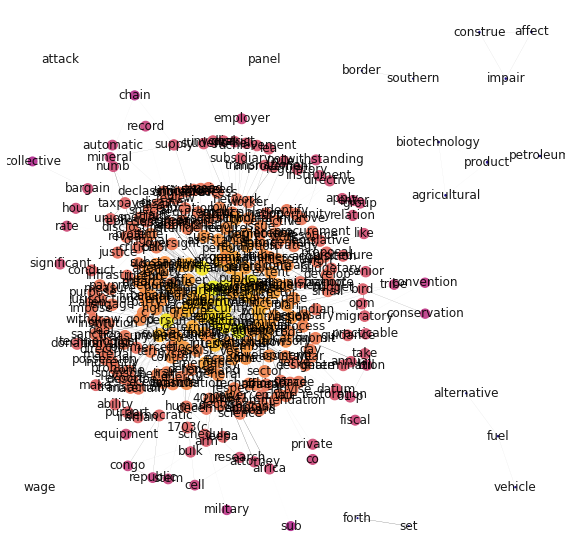

In [908]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

In [909]:
# top words for closeness centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('law', 0.4915397884199296),
 ('president', 0.48911841015185115),
 ('provide', 0.4788956781068767),
 ('information', 0.4735661554570387),
 ('person', 0.47281446314678943),
 ('executive', 0.4690915146180746),
 ('national', 0.467618699815506),
 ('federal', 0.4661551045109191),
 ('act', 0.46542673716012084),
 ('security', 0.4611038882081693)]

In [910]:
# bottom words for closeness centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('petroleum', 0.005438066465256798),
 ('alternative', 0.004028197381671702),
 ('vehicle', 0.004028197381671702),
 ('border', 0.0030211480362537764),
 ('forth', 0.0030211480362537764),
 ('set', 0.0030211480362537764),
 ('southern', 0.0030211480362537764),
 ('attack', 0.0),
 ('wage', 0.0),
 ('panel', 0.0)]

What about eigenvector centrality?

In [911]:
centralities = nx.eigenvector_centrality(giant)

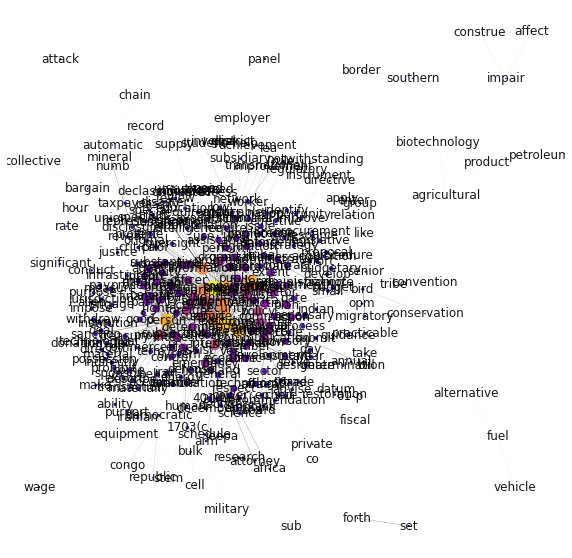

In [912]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

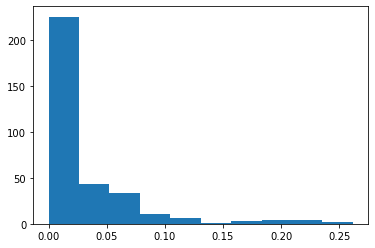

In [913]:
plt.hist(list(centralities.values()))
plt.show()

Eigenvector centrality has a more gradual distribution rather than being only concentrated at the low end.

In [914]:
# top entries
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('law', 0.2617629947893732),
 ('executive', 0.2359777936846745),
 ('president', 0.22618302730907797),
 ('federal', 0.21760885141696715),
 ('person', 0.21679337585601313),
 ('act', 0.20956074654329165),
 ('provide', 0.20646461128777704),
 ('national', 0.2053251489885664),
 ('security', 0.1907290074457977),
 ('information', 0.18764370969527697)]

In [915]:
# bottom entries
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('construe', 7.730346678984904e-16),
 ('affect', 7.730346678984904e-16),
 ('impair', 7.730346678984904e-16),
 ('border', 1.1735446988368476e-16),
 ('southern', 7.252905111985416e-17),
 ('attack', 1.7653470050156246e-18),
 ('wage', 1.7653470050156246e-18),
 ('forth', 1.7653470050156246e-18),
 ('set', 1.7653470050156246e-18),
 ('panel', 1.7653470050156246e-18)]

Generally, the different centrality measures flag almost the same set of nodes as being the most central. This is because the corpus of executive orders doesn't allow for a lot of creative license when it comes to linguistic style. Though they may have different focuses, executive orders follow a formal structure and focus on logistics of implementation, which can take a similar process (delegating committees, earmarking funds, etc.) no matter the context.

Now let's filter on betweenness.

In [927]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 163
Average degree:  13.0400


NetworkXError: Node 'power' has no position.

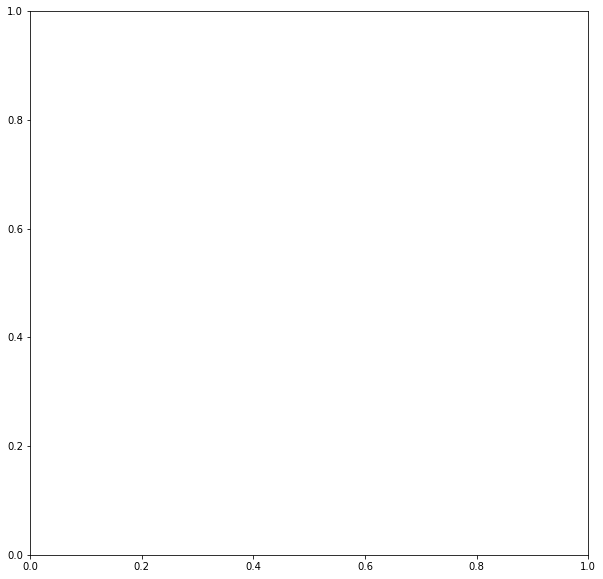

In [928]:
layout = nx.nx_agraph.graphviz_layout(giant_filtered30)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [923]:
#giant = max(connected_component_subgraphs(giant), key=len)

In [925]:
# global density
nx.density(giant)


0.02794459609746234

In [926]:
np.mean([v for w,v in nx.degree(giant)])

8.774603174603175

In [920]:
giant.remove_nodes_from(list(nx.isolates(giant)))

In [924]:
nx.diameter(giant) # what to do about this? REMOVE ISOLATES AGAIN

7

Our global measures show that the mean degree is about 8.5 and the diameter is 7. This means that we have a lot of moderately-connected graphs in our network.

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [358]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [359]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, when,...  
98  [[https://www.reddit.com/r/relationships/comme...  
97  [[First, post, https://www.reddit.com/r/relati...

Let's look at a few things here, especially some things about Pandas that might come in handy later on.

First, sort_values('score'): sort_values is a function used for Pandas DataFrame to literally sort the values. Here, it sorts the values from the lowest one to the highest one. So, by doing "redditDF.sort_values('score')[-100:]", it gets us 100 rows, from the 100th highest one (-99) to the highest one (0). Why not -100 and 1 rather than -99 and 0? That's just how Python works.

Second, .index: it literally gives you the index of the Pandas DataFrame. You can also reindex the indices here. But what does "range(len(redditTopScores) - 1, -1,-1)" do? It generates a range from len(redditTopScores)-1 to -1 by increments of -1. So, a range from 99 to -1, by -1, i.e., 99, 98, 97...0.

Now we'll normalize the tokens through stemming:

In [360]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will revisit spacy and use it's english language model.

In [361]:
import spacy

In [362]:
nlp = spacy.load('en')

In [363]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [364]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [365]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 1886
Number of edges: 11543
Average degree:  12.2407


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [366]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 22
Number of edges: 182
Average degree:  16.5455


And low weight edges:

In [367]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 22
Number of edges: 74
Average degree:   6.7273


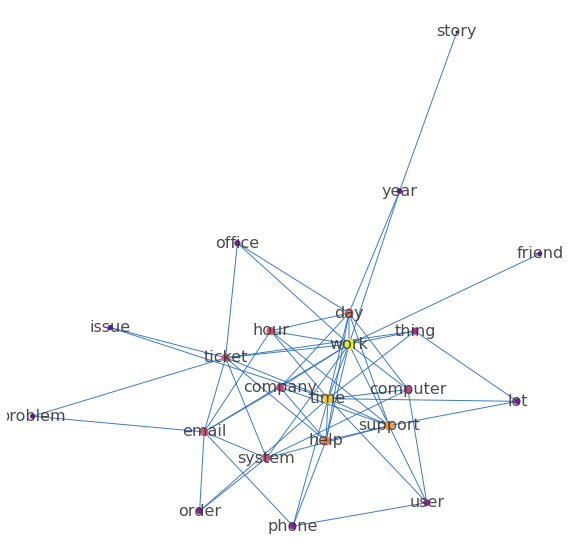

In [368]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

This makes sense: people are talking about work, support, computers, time... it's a tech support forum, so these are expected connections.

What if we want to look at noun-verb pairs instead?

In [369]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [370]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 18050
Average degree:  17.5243


In [371]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [372]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 6448
Average degree:   6.2602


Dropping low weight edges and low degree vertices gives us:

In [373]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [374]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 77
Average degree:   5.1333


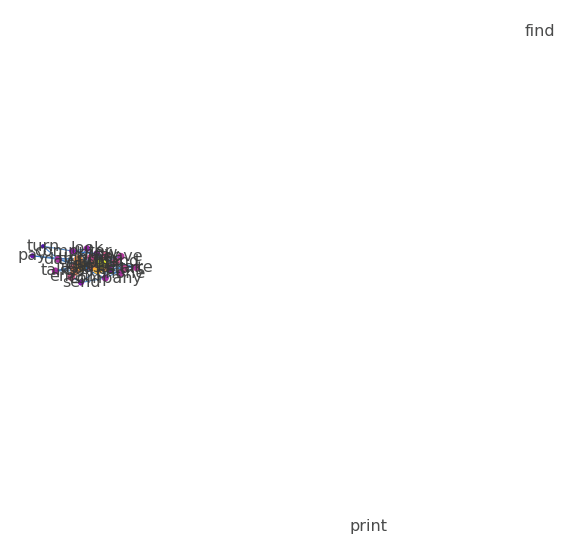

In [375]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [376]:
g_i = gNV.subgraph(['work'] + list(gNV.neighbors('work')))

In [377]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 13
Average degree:   1.8571


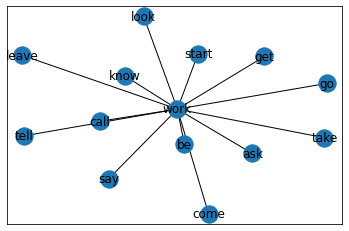

In [378]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [379]:
storyNeighbors = gNV.neighbors('look')
set(storyNeighbors)

{'computer', 'thing', 'work'}

In [380]:
storyNeighbors = set(gNV.neighbors('look'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [381]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 27
Average degree:   3.0000


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [382]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.7647058823529411),
 ('thing', 0.5294117647058824),
 ('computer', 0.29411764705882354),
 ('get', 0.1764705882352941),
 ('look', 0.1764705882352941),
 ('say', 0.1764705882352941),
 ('leave', 0.11764705882352941),
 ('be', 0.11764705882352941),
 ('ask', 0.11764705882352941),
 ('go', 0.11764705882352941)]

Or eigenvector centrality:

In [383]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.5321606315017264),
 ('thing', 0.4140474999760912),
 ('get', 0.25401847319001947),
 ('look', 0.25401847319001947),
 ('say', 0.25401847319001947),
 ('computer', 0.21299832183727044),
 ('leave', 0.20734386356098644),
 ('be', 0.20734386356098644),
 ('ask', 0.20734386356098644),
 ('go', 0.20734386356098644)]

Lets plot it:

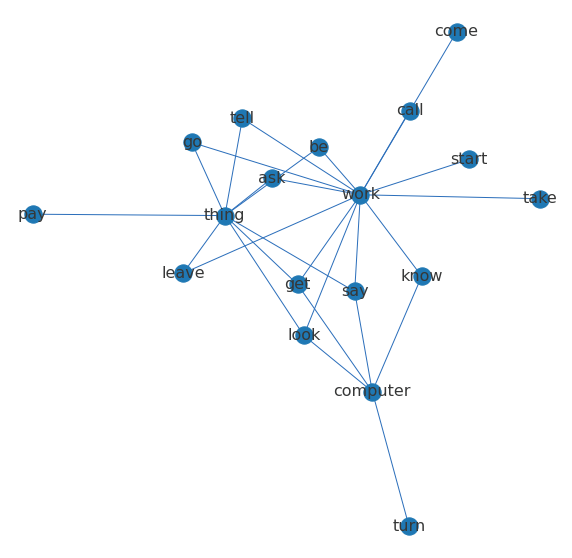

In [384]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Lets create a noun-adjective network:

In [385]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 2515
Number of edges: 19194
Average degree:  15.2636


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [386]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 88
Average degree:   7.0400


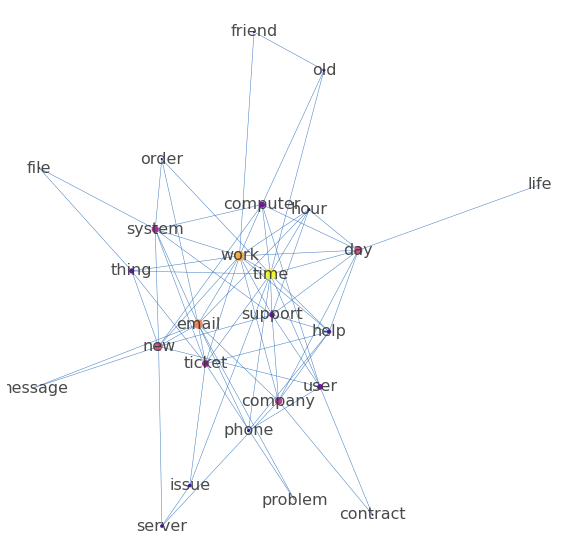

In [387]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [388]:
small_exec

Unnamed: 0     citation document_number  end_page  \
95           95  79 FR 34999      2014-14429     35027   
18           18  81 FR 78697      2016-27156     78700   
182         182  76 FR 52209      2011-21505     52211   
62           62  80 FR 46177      2015-19183     46180   
248         248  74 FR 56521        E9-26408     56522   
..          ...          ...             ...       ...   
603         603  65 FR 41543        00-17174     41543   
589         589  65 FR 67249        00-29003     67252   
607         607  65 FR 34035        00-13367     34037   
583         583  65 FR 81321        00-33004     81323   
574         574   66 FR 5421         01-1813      5423   

                                              html_url  \
95   https://www.federalregister.gov/documents/2014...   
18   https://www.federalregister.gov/documents/2016...   
182  https://www.federalregister.gov/documents/2011...   
62   https://www.federalregister.gov/documents/2015...   
248  https://www.federalregister.gov/documents/2009...   
..                                                 ...   
603  https://www.federalregister.gov/documents/2000...   
589  https://www.federalregister.gov/documents/2000...   
607  https://www.federalregister.gov/documents/2000...   
583  https://www.federalregister.gov/documents/2000...   
574  https://www.federalregister.gov/documents/2001...   

                                               pdf_url                   type  \
95   https://www.govinfo.gov/content/pkg/FR-2014-06...  Presidential Document   
18   https://www.govinfo.gov/content/pkg/FR-2016-11...  Presidential Document   
182  https://www.govinfo.gov/content/pkg/FR-2011-08...  Presidential Document   
62   https://www.govinfo.gov/content/pkg/FR-2015-08...  Presidential Document   
248  https://www.govinfo.gov/content/pkg/FR-2009-11...  Presidential Document   
..                                                 ...                    ...   
603  https://www.govinfo.gov/content/pkg/FR-2000-07...  Presidential Document   
589  https://www.govinfo.gov/content/pkg/FR-2000-11...  Presidential Document   
607  https://www.govinfo.gov/content/pkg/FR-2000-05...  Presidential Document   
583  https://www.govinfo.gov/content/pkg/FR-2000-12...  Presidential Document   
574  https://www.govinfo.gov/content/pkg/FR-2001-01...  Presidential Document   

             subtype publication_date signing_date  start_page  \
95   Executive Order       06/18/2014   06/13/2014       34999   
18   Executive Order       11/08/2016   11/03/2016       78697   
182  Executive Order       08/22/2011   08/17/2011       52209   
62   Executive Order       08/03/2015   07/29/2015       46177   
248  Executive Order       11/02/2009   10/28/2009       56521   
..               ...              ...          ...         ...   
603  Executive Order       07/05/2000   06/29/2000       41541   
589  Executive Order       11/09/2000   11/06/2000       67249   
607  Executive Order       05/25/2000   05/23/2000       34033   
583  Executive Order       12/26/2000   12/20/2000       81321   
574  Executive Order       01/19/2001   01/15/2001        5421   

                                                 title  \
95   2014 Amendments to the Manual for Courts-Marti...   
18   Advancing the Goals of the Power Africa Initia...   
182  Blocking Property of the Government of Syria a...   
62   Creating a National Strategic Computing Initia...   
248                     Amending Executive Order 13462   
..                                                 ...   
603  Establishment of the Presidential Medal of Val...   
589  Consultation and Coordination With Indian Trib...   
607  Increasing Opportunities for Women-Owned Small...   
583  To Protect the Privacy of Protected Health Inf...   
574  Federal Interagency Task Force on the District...   

                                     disposition_notes  \
95                    Amends: EO 12473, April 13, 1984   
18                              

In [414]:
gNN = posCooccurrence(small_exec['normalized_sents'].sum(), 'NN')

In [415]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 1884
Number of edges: 55691
Average degree:  59.1200


In [416]:
# filter out degree under 120
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 120]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 258
Number of edges: 15706
Average degree: 121.7519


In [417]:
# filter out weight under 3
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 3])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 258
Number of edges: 5197
Average degree:  40.2868


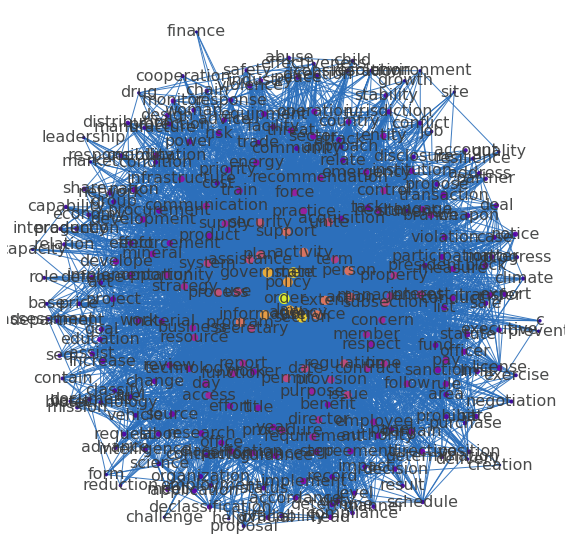

In [922]:
layout_nn = nx.nx_agraph.graphviz_layout(gNN)

#layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [395]:
gNV = posCooccurrence(small_exec['normalized_sents'].sum(), 'NN', 'VB')

In [419]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [420]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2031
Number of edges: 15662
Average degree:  15.4229


In [421]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [422]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 257
Number of edges: 2223
Average degree:  17.2996


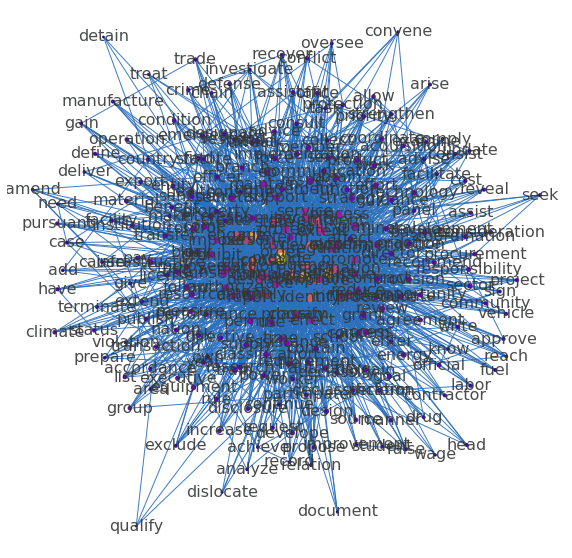

In [496]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality_numpy(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Let's look at an ego network surrounding energy, as I am especially interested in energy-related executive orders.

In [424]:
g_i = gNV.subgraph(['energy'] + list(gNV.neighbors('energy')))

In [425]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 10
Average degree:   1.8182


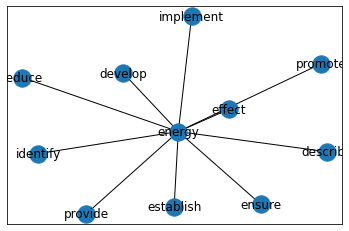

In [426]:
nx.draw_networkx(g_i)

In [427]:
# now let's look at 2 hops away
storyNeighbors = gNV.neighbors('energy')
set(storyNeighbors)

{'describe',
 'develop',
 'effect',
 'ensure',
 'establish',
 'identify',
 'implement',
 'promote',
 'provide',
 'reduce'}

In [428]:
storyNeighbors = set(gNV.neighbors('energy'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [429]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 175
Number of edges: 725
Average degree:   8.2857


In [430]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]


[('provide', 0.8160919540229885),
 ('ensure', 0.603448275862069),
 ('establish', 0.5862068965517241),
 ('implement', 0.43103448275862066),
 ('identify', 0.40804597701149425),
 ('develop', 0.40804597701149425),
 ('promote', 0.2471264367816092),
 ('describe', 0.24137931034482757),
 ('reduce', 0.21839080459770116),
 ('effect', 0.20689655172413793)]

In [550]:
sorted(nx.eigenvector_centrality_numpy(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]


[('provide', 0.3522879210796883),
 ('ensure', 0.2961262205723149),
 ('establish', 0.2912900743586514),
 ('implement', 0.2303692886953546),
 ('develop', 0.2154189143310203),
 ('identify', 0.21177336524574766),
 ('promote', 0.13310711565234115),
 ('describe', 0.12820705201925728),
 ('effect', 0.11331214291059571),
 ('reduce', 0.1097046239783241)]

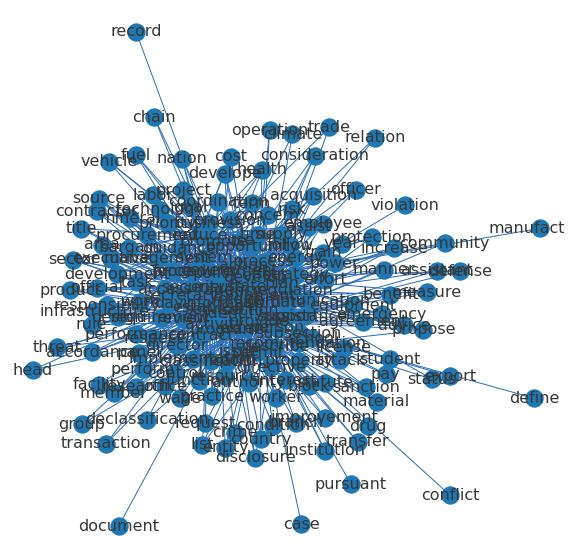

In [432]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

In [433]:
# Now let's look at a noun-adjective network
gNJ = posCooccurrence(small_exec['normalized_sents'].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 2520
Number of edges: 99686
Average degree:  79.1159


In [434]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 296
Average degree:  23.6800


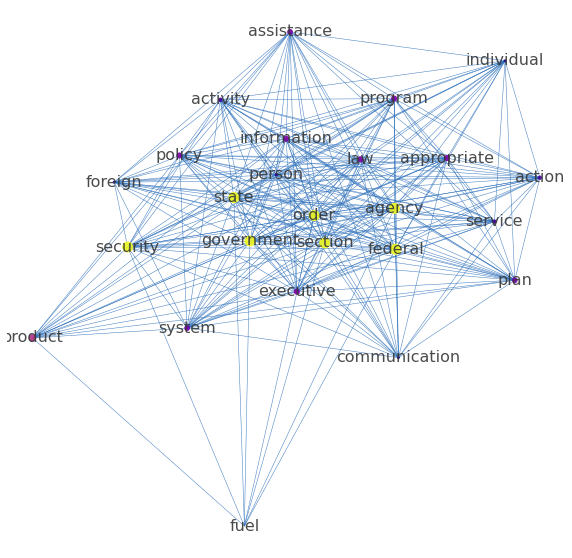

In [435]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## Creating networks of agents from corpora

Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
The code returns a dictionary with each id mapping to the text associated with it. 

We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

This function might take some time.

In [447]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [449]:
#soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [ ]:
import zipfile

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

In [ ]:
import pandas as pd

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 9th corpora, and I conducted my basic analysis on that.

In [ ]:
dool = soap_df['Tokenized Texts'][3]

In [ ]:
' '.join(dool[0:1500])

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [ ]:
characters = {}

In [ ]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [ ]:
len(characters)

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [ ]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

In [ ]:
Image(filename='../data/dool/dool_john.png') 

In [ ]:
Image(filename='../data/dool/dool_brady.jpg') 

In [ ]:
Image(filename='../data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_marlena.jpg')

In [ ]:
Image(filename='../data/dool/dool_kate.png')

In [ ]:
Image(filename='../data/dool/dool_bo.png')

In [ ]:
Image(filename='../data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='../data/dool/dool_sami.jpg')

In [ ]:
Image(filename='../data/dool/dool_shawn.jpg')

In [ ]:
Image(filename='../data/dool/dool_belle.jpg')

In [ ]:
Image(filename='../data/dool/dool_lucas.jpg')

In [ ]:
Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
len(actor_network.nodes.data())

In [ ]:
actor_network.nodes.data()

In [ ]:
actor_network.nodes['Sami']['lines_spoken']

In [ ]:
i = 0

The following lines of code creates the graph. Please carefully go through the code: you should be able to understand (more or less) what is going on here. 

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [450]:
import seaborn as sns

In [ ]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [ ]:
c

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [ ]:
smaller_actor_network = nx.Graph()

In [ ]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


In [ ]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [ ]:
c

In [ ]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [ ]:
dcentralities['John'], dcentralities['Philip']

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [436]:
import nltk

In [437]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [ ]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [ ]:
L = []

In [ ]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id

In [438]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
import lucem_illud_2020
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language )

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [454]:
bills_meta = pd.read_csv('/Users/lilygrier/Documents/Grad_School/Computational Content Analysis/bills93-114.csv', 
                         error_bad_lines=False, encoding='latin-1')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [458]:
# does an exec order mention a different exec order?
import re

In [461]:
order = exec_orders[exec_orders['executive_order_number'] == 13889]

In [473]:
order_text = order['order_text'].iloc[0]

In [491]:
def get_orders_mentioned(text):
    return [int(num) for num in re.findall(r'Executive Order (\d+)', text)]

In [492]:
#get_orders_mentioned(order_text)

In [493]:
order['mentions'] = order['order_text'].apply(lambda x: get_orders_mentioned(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [494]:
small_exec['mentions'] = small_exec['order_text'].apply(lambda x: get_orders_mentioned(x))

In [531]:
exec_orders['mentions'] = exec_orders['order_text'].apply(lambda x: get_orders_mentioned(x))

In [504]:
len(small_exec['mentions'])

100

In [532]:
exec_orders[exec_orders['mentions'].map(len) > 1].shape


(502, 19)

In [509]:
small_exec.columns

Index(['Unnamed: 0', 'citation', 'document_number', 'end_page', 'html_url',
       'pdf_url', 'type', 'subtype', 'publication_date', 'signing_date',
       'start_page', 'title', 'disposition_notes', 'executive_order_number',
       'president', 'order_text', 'tokenized_sents', 'normalized_sents',
       'mentions'],
      dtype='object')

In [663]:
exec_orders['executive_order_number'] = exec_orders['executive_order_number'].apply(lambda x: int(x))

In [664]:
exec_orders['executive_order_number']

0       13764
1       13762
2       13763
3       13761
4       13758
        ...  
1037    13769
1038    13766
1039    13767
1040    13768
1041    13765
Name: executive_order_number, Length: 839, dtype: int64

In [714]:
orders_network = nx.Graph()

In [716]:
for ind, order in exec_orders.iterrows():
    orders_network.add_node(order.executive_order_number, text = order.normalized_sents, pres=order.president)

In [717]:
len(orders_network.nodes.data())

839

In [718]:
# for ind, order in exec_orders.iterrows():
#     num = order.executive_order_number
#     #if len(order.mentions) > 1:
#     for mention in order.mentions:
#         if mention != num and mention in orders_network.nodes():
#             if (num, mention) not in orders_network.edges():
#                 orders_network.add_edge(num, int(mention), weight=0)
#             if (num, mention) in orders_network.edges():
#                 orders_network.edges[(num, mention)]['weight'] += 1


In [719]:
import itertools

In [730]:
# make network of orders that are mentioned together
def increase_weight(orders_network, order_1, order_2):
    if (order_1 in orders_network.nodes()) and (order_2 in orders_network.nodes()) and (order_1 != order_2):
            if (order_1, order_2) not in orders_network.edges():
                orders_network.add_edge(order_1, order_2, weight=0)
            #if (num, mention) in orders_network.edges():
            orders_network.edges[(order_1, order_2)]['weight'] += 1
            #print('increased weight')
    

In [731]:
for ind, order in exec_orders.iterrows():
    pairs = list(itertools.combinations(order.mentions, 2))
    for (order_1, order_2) in pairs:
        increase_weight(orders_network, order_1, order_2)

increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weig

increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weig

increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weig

increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weig

increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weight
increased weig

In [732]:
print(nx.info(orders_network))

Name: 
Type: Graph
Number of nodes: 512
Number of edges: 1504
Average degree:   5.8750


In [733]:
orders_network.remove_nodes_from(list(nx.isolates(orders_network)))

In [734]:
print(nx.info(orders_network))

Name: 
Type: Graph
Number of nodes: 512
Number of edges: 1504
Average degree:   5.8750


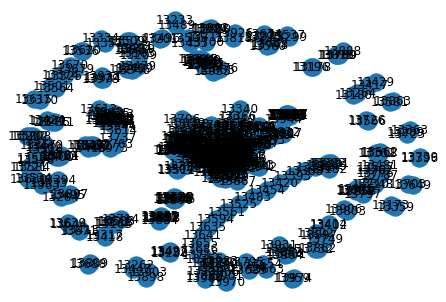

In [738]:
nx.draw(orders_network, with_labels=True)

In [735]:
edges=sorted(orders_network.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)

In [737]:
edges

[(13488, 13467, {'weight': 241}),
 (13315, 13303, {'weight': 86}),
 (13526, 13467, {'weight': 62}),
 (13448, 13310, {'weight': 57}),
 (13628, 13599, {'weight': 48}),
 (13467, 13381, {'weight': 48}),
 (13391, 13288, {'weight': 44}),
 (13464, 13448, {'weight': 33}),
 (13315, 13290, {'weight': 33}),
 (13619, 13448, {'weight': 26}),
 (13213, 13194, {'weight': 26}),
 (13653, 13514, {'weight': 25}),
 (13549, 13467, {'weight': 25}),
 (13399, 13338, {'weight': 25}),
 (13460, 13338, {'weight': 24}),
 (13764, 13467, {'weight': 23}),
 (13572, 13338, {'weight': 22}),
 (13549, 13526, {'weight': 20}),
 (13303, 13290, {'weight': 19}),
 (13526, 13488, {'weight': 18}),
 (13488, 13381, {'weight': 18}),
 (13464, 13310, {'weight': 18}),
 (13619, 13310, {'weight': 16}),
 (13364, 13303, {'weight': 16}),
 (13661, 13660, {'weight': 15}),
 (13350, 13315, {'weight': 15}),
 (13514, 13423, {'weight': 14}),
 (13619, 13464, {'weight': 13}),
 (13692, 13808, {'weight': 12}),
 (13622, 13599, {'weight': 12}),
 (13551, 

In [739]:
orders_network.edges[(13757, 13849)]

{'weight': 1}

In [764]:
smaller_orders = nx.Graph()
for order_1 in orders_network.nodes():
    order_1 = int(order_1)
    smaller_orders.add_node(order_1, text=orders_network.nodes[order_1]['text'], 
                            pres=orders_network.nodes[order_1]['pres'])
    for order_2 in orders_network.nodes():
        order_2 = int(order_2)
        if ((order_1, order_2) in orders_network.edges()) and orders_network.edges[(order_1, order_2)]['weight'] > 3:
            smaller_orders.add_edge(order_1, order_2, weight=orders_network.edges[(order_1, order_2)]['weight'])

In [765]:
smaller_orders.remove_nodes_from(list(nx.isolates(smaller_orders)))

In [766]:
print(nx.info(smaller_orders))

Name: 
Type: Graph
Number of nodes: 173
Number of edges: 245
Average degree:   2.8324


In [767]:
# let's make this more manageable by only taking items that appear together a lot

In [768]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_orders))

In [769]:
c

[frozenset({13226,
            13228,
            13231,
            13237,
            13256,
            13265,
            13270,
            13381,
            13408,
            13436,
            13467,
            13488,
            13498,
            13507,
            13515,
            13521,
            13522,
            13526,
            13532,
            13538,
            13539,
            13540,
            13544,
            13549,
            13555,
            13569,
            13585,
            13600,
            13621,
            13634,
            13636,
            13652,
            13708,
            13764,
            13869}),
 frozenset({13224,
            13268,
            13338,
            13382,
            13399,
            13460,
            13466,
            13551,
            13570,
            13572,
            13573,
            13687,
            13722,
            13810}),
 frozenset({13148, 13327, 13423, 13432, 13514, 13604, 13653, 1367

Let's see how similar nodes that are mentioned together appear to be.

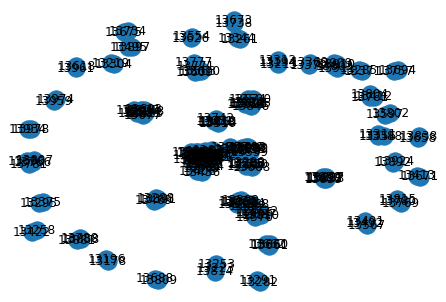

In [770]:
nx.draw(smaller_orders, with_labels=True)

To make things easier to examine, let's take 40 nodes at random from this graph of items with relatively high weights and look at connections between them. The nature of executive orders lends itself to smaller communities. While it is common for orders to reference one another, it is not likely we'll see a ton of back-and-forth with orders.

In [782]:
# plot 40 at random
import random
k = 40
sampled_nodes = random.sample(smaller_orders.nodes, k)
sampled_graph = smaller_orders.subgraph(sampled_nodes)

In [783]:
def plot_network_weights(smaller_orders):
    L = []
    for node in smaller_orders.nodes():
        l = []
        for node_ in smaller_orders.nodes():
            if node == node_:
                l.append(0)
            else:
                if (node, node_) in smaller_orders.edges():
                    l.append(smaller_orders.edges[(node, node_)]['weight'])
                else:
                    l.append(0)
        L.append(l)
    M_ = np.array(L)
    fig = plt.figure()
    div = pandas.DataFrame(M_, columns = list(smaller_orders.nodes()), index = list(smaller_orders.nodes()))
    ax = sns.heatmap(div)
    plt.show()

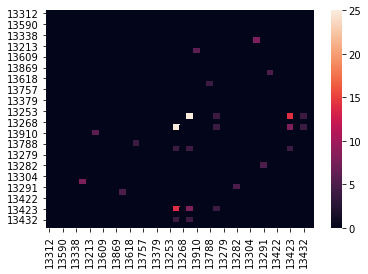

In [784]:
plot_network_weights(sampled_graph)

In [792]:
# now let's look at divergences for this sampled graph
corpora = []
for order in sampled_graph.nodes():
    order_sents = []
    for sentence in sampled_graph.nodes[order]['text']:
        order_sents.append(sentence)
    corpora.append(order_sents)

In [797]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(np.concatenate(p, axis=0),np.concatenate(q, axis=0), difference='KS'))
    L.append(l)
M = np.array(L)

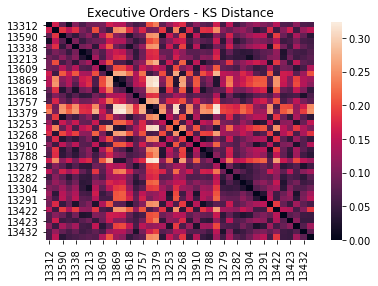

In [799]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(sampled_graph.nodes()), index = list(sampled_graph.nodes()))
ax = sns.heatmap(div)
plt.title('Executive Orders - KS Distance')
plt.show()

Due to the more silo-ed networks of executive orders being represented in this sample, it's pretty difficult to tell if the few nodes that often appear in tandem also have high weights.